In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import sys
import warnings
from pathlib import Path
from typing import Dict

import pandas as pd
from rich import traceback
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger

In [3]:
src_path: str = "../src"
sys.path.append(src_path)

_ = traceback.install()
rpy2_logger.setLevel(logging.ERROR)
logging.basicConfig(force=True)
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [4]:
import rpy2.robjects as ro

from components.functional_analysis.orgdb import OrgDB
from r_wrappers.complex_heatmaps import complex_heatmap, heatmap_annotation
from r_wrappers.utils import map_gene_id

org_db = OrgDB("Homo sapiens")

In [5]:
ROOT_PATH: Path = Path("/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_FILTERED")
FIGURES_PATH: Path = ROOT_PATH.joinpath("manuscript_figures")
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

In [6]:
ANNOT_DF = pd.read_csv(ROOT_PATH / "data" / "samples_annotation.csv", index_col=0)

VST_DF = pd.read_csv(
    ROOT_PATH / "deseq2" / "sample_type_hspc+mcrpc+norm+prim__vst.csv", index_col=0
)
VST_DF.index = map_gene_id(VST_DF.index, org_db, "ENSEMBL", "SYMBOL")
VST_DF = VST_DF.loc[~VST_DF.index.str.contains("/", na=False)]
VST_DF = VST_DF.loc[VST_DF.index.dropna().drop_duplicates(keep=False)]

CONTRASTS_LEVELS_COLORS = {
    "mcrpc": "#8B3A3A",
    "prim": "#4A708B",
    "hspc": "#8B008B",
    "norm": "#9ACD32",
}

CONTRASTS_LEVELS_ORDER = ["norm", "prim", "hspc", "mcrpc"]

## Integrative analysis of Differential Expression, WGCNA and ML results

---


## 1. Identify the most promising module combinations

In [7]:
results_path = ROOT_PATH / "integrative_analysis" / "intersecting_wgcna_pathways"
wgcna_int_results = {}

for int_wgcna_file in results_path.rglob("*.csv"):
    file_name = int_wgcna_file.stem
    if "up" in file_name or "down" in file_name:
        wgcna_int_results[file_name] = {
            "file_path": str(int_wgcna_file),
            "count": int(file_name.split("_")[-1]),
        }
wgcna_int_results_df = pd.DataFrame(wgcna_int_results).T.sort_values(
    "count", ascending=False
)

In [8]:
display(wgcna_int_results_df[:5].to_dict("index"))

{'comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_pathways_M3+M2+M1_20': {'file_path': '/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_FILTERED/integrative_analysis/intersecting_wgcna_pathways/REACTOME/comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_pathways_M3+M2+M1_20.csv',
  'count': 20},
 'comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_pathways_M3+M2+M1_1': {'file_path': '/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_FILTERED/integrative_analysis/intersecting_wgcna_pathways/DO/comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_pathways_M3+M2+M1_1.csv',
  'count': 1},
 'comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_pathways_M3+M5+M2_0': {'file_path': '/media/ssd/Perez/storage/PCTA_WCDT_GSE221601_FILTERED/integrative_analysis/intersecting_wgcna_pathways/REACTOME/comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_pathways_M3+M5+M2_0.csv',
  'count': 0},
 'comparison_0_padj_0_05_up_1_0_bicor_signed_intersecti

In [9]:
CHOSEN_PATH: Path = Path(wgcna_int_results_df.iloc[0]["file_path"])

In [10]:
WGCNA_INT_PATHWAYS_DF: pd.DataFrame = pd.read_csv(CHOSEN_PATH)
WGCNA_MODULES: Dict[str, str] = {
    "_".join(contrast.split("_")[:-1]): contrast.split("_")[-1]
    for contrast in WGCNA_INT_PATHWAYS_DF.columns[:3]
}

print(WGCNA_MODULES)

{'prim_vs_norm': 'M3', 'hspc_vs_prim': 'M2', 'mcrpc_vs_hspc': 'M1'}


## 2. Get shared genes between chosen WGCNA modules and ML results

Check average test scores per contrast

In [11]:
scores = {}
for test_scores_file in (ROOT_PATH / "ml_classifiers").rglob(
    "bootstrap_10000_test_scores.csv"
):
    test_scores_df = pd.read_csv(test_scores_file, index_col=0)
    scores[test_scores_file.parents[3].stem] = test_scores_df.mean()
pd.DataFrame(scores).T

,average_precision,F1S,balanced_accuracy
sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_all_1_0,0.997609,0.997854,0.983870
sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_up_1_0,0.976799,0.979974,0.953950
sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_up_1_0,0.986419,0.947954,0.905609
sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_all_1_0,0.964713,0.964182,0.928375
sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_down_1_0,0.999268,0.999615,0.995092
sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_all_1_0,0.989547,0.991338,0.963127
sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_up_1_0,0.988415,0.978617,0.957802
sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_down_1_0,0.974276,0.986848,0.909147
sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_down_1_0,0.980829,0.985001,0.962460


Shared DEGs between WGCNA modules fltered by SHAP values

In [12]:
results_path = (
    ROOT_PATH
    / "integrative_analysis"
    / "intersecting_wgcna_shap"
    / "random_forest_10000"
)
ml_path_pattern = "_".join(
    CHOSEN_PATH.stem.split("_")[:-1]
).replace(
    "intersecting_wgcna_pathways",
    "random_forest_10000_shap_values_1e-05_intersecting_wgcna",
)
wgcna_ml_results_path = next(results_path.glob(f"{ml_path_pattern}*.csv"))
print("Results file path:\n", wgcna_ml_results_path)
wgcna_ml_results = pd.read_csv(wgcna_ml_results_path, index_col=0)
print("Shape:\n", wgcna_ml_results.shape)
display(wgcna_ml_results.head())

Results file path:
 /media/ssd/Perez/storage/PCTA_WCDT_GSE221601_FILTERED/integrative_analysis/intersecting_wgcna_shap/random_forest_10000/comparison_0_padj_0_05_up_1_0_bicor_signed_random_forest_10000_shap_values_1e-05_intersecting_wgcna_M3+M2+M1_ENTREZID_22.csv
Shape:
 (201, 8)


,prim_vs_norm_M3,hspc_vs_prim_M2,mcrpc_vs_hspc_M1,module,stat,SYMBOL,GENENAME,GENETYPE
ENTREZID,,,,,,,,
9232,True,True,True,M3,12.142774,PTTG1,PTTG1 regulator of sister chromatid separation...,protein-coding
1058,True,True,True,M3,14.746854,CENPA,centromere protein A,protein-coding
1063,True,True,True,M3,18.528588,CENPF,centromere protein F,protein-coding
9787,True,True,True,M3,17.270347,DLGAP5,DLG associated protein 5,protein-coding
24137,True,True,True,M3,19.737857,KIF4A,kinesin family member 4A,protein-coding


### 2.1. Heatmap of shared genes filtered by SHAP values

In [22]:
wgcna_ml_results_filt = wgcna_ml_results.loc[
    wgcna_ml_results["prim_vs_norm_M3"]
    & wgcna_ml_results["hspc_vs_prim_M2"]
    & wgcna_ml_results["mcrpc_vs_hspc_M1"]
]
vst_filt = VST_DF.loc[wgcna_ml_results_filt["SYMBOL"]]
counts_matrix = vst_filt.sub(vst_filt.mean(axis=1), axis=0)

In [23]:
# Create column annotation for sample types
ha_column = heatmap_annotation(
    df=ANNOT_DF[["sample_type"]].loc[counts_matrix.columns],
    col={"sample_type": CONTRASTS_LEVELS_COLORS},
    show_annotation_name=True,
    annotation_legend_param=ro.ListVector(
        {"sample_type": ro.ListVector({"at": ro.StrVector(CONTRASTS_LEVELS_ORDER)})}
    ),
)

# Generate heatmap
complex_heatmap(
    counts_matrix,
    save_path=FIGURES_PATH / f"{wgcna_ml_results_path.stem}_shared_genes_heatmap.pdf",
    width=10,
    height=8,
    name="VST",
    column_title=(
        "Shared genes (SHAP > 1e-5) between WGCNA modules M3 (prim vs norm), "
        "M2 (hspc vs prim) and M1 (mcrpc vs hspc)"
    ),
    top_annotation=ha_column,
    show_row_names=True,
    show_column_names=False,
    cluster_columns=False,
    cluster_rows=True,
    column_split=ro.r.factor(
        ro.StrVector(ANNOT_DF["sample_type"].loc[counts_matrix.columns].tolist()),
        levels=ro.StrVector(CONTRASTS_LEVELS_ORDER),
    ),
    cluster_column_slices=False,
    heatmap_legend_param=ro.r('list(title="VST")'),
)

### 2.2. Heatmap of genes filtered by SHAP values only in prim/norm

In [24]:
wgcna_ml_results_filt = wgcna_ml_results.loc[
    wgcna_ml_results["prim_vs_norm_M3"]
    & ~wgcna_ml_results["hspc_vs_prim_M2"]
    & ~wgcna_ml_results["mcrpc_vs_hspc_M1"]
]
vst_filt = VST_DF.loc[wgcna_ml_results_filt["SYMBOL"]]
counts_matrix = vst_filt.sub(vst_filt.mean(axis=1), axis=0)

In [25]:
# Create column annotation for sample types
ha_column = heatmap_annotation(
    df=ANNOT_DF[["sample_type"]].loc[counts_matrix.columns],
    col={"sample_type": CONTRASTS_LEVELS_COLORS},
    show_annotation_name=True,
    annotation_legend_param=ro.ListVector(
        {"sample_type": ro.ListVector({"at": ro.StrVector(CONTRASTS_LEVELS_ORDER)})}
    ),
)

# Generate heatmap
complex_heatmap(
    counts_matrix,
    save_path=FIGURES_PATH / f"{wgcna_ml_results_path.stem}_prim_norm_genes_heatmap.pdf",
    width=10,
    height=8,
    name="VST",
    column_title=(
        "Genes (SHAP > 1e-5) only in WGCNA module M3 (prim/norm)"
    ),
    top_annotation=ha_column,
    show_row_names=True,
    show_column_names=False,
    cluster_columns=False,
    cluster_rows=True,
    column_split=ro.r.factor(
        ro.StrVector(ANNOT_DF["sample_type"].loc[counts_matrix.columns].tolist()),
        levels=ro.StrVector(CONTRASTS_LEVELS_ORDER),
    ),
    cluster_column_slices=False,
    heatmap_legend_param=ro.r('list(title="VST")'),
)

### 2.3. Heatmap of genes filtered by SHAP values only in hspc/prim

In [26]:
wgcna_ml_results_filt = wgcna_ml_results.loc[
    ~wgcna_ml_results["prim_vs_norm_M3"]
    & wgcna_ml_results["hspc_vs_prim_M2"]
    & ~wgcna_ml_results["mcrpc_vs_hspc_M1"]
]
vst_filt = VST_DF.loc[wgcna_ml_results_filt["SYMBOL"]]
counts_matrix = vst_filt.sub(vst_filt.mean(axis=1), axis=0)

In [27]:
# Create column annotation for sample types
ha_column = heatmap_annotation(
    df=ANNOT_DF[["sample_type"]].loc[counts_matrix.columns],
    col={"sample_type": CONTRASTS_LEVELS_COLORS},
    show_annotation_name=True,
    annotation_legend_param=ro.ListVector(
        {"sample_type": ro.ListVector({"at": ro.StrVector(CONTRASTS_LEVELS_ORDER)})}
    ),
)

# Generate heatmap
complex_heatmap(
    counts_matrix,
    save_path=FIGURES_PATH
    / f"{wgcna_ml_results_path.stem}_hspc_prim_genes_heatmap.pdf",
    width=10,
    height=8,
    name="VST",
    column_title=("Genes (SHAP > 1e-5) only in WGCNA module M3 (hspc/prim)"),
    top_annotation=ha_column,
    show_row_names=True,
    show_column_names=False,
    cluster_columns=False,
    cluster_rows=True,
    column_split=ro.r.factor(
        ro.StrVector(ANNOT_DF["sample_type"].loc[counts_matrix.columns].tolist()),
        levels=ro.StrVector(CONTRASTS_LEVELS_ORDER),
    ),
    cluster_column_slices=False,
    heatmap_legend_param=ro.r('list(title="VST")'),
    row_names_gp=ro.r("gpar(fontsize = 8)"),
)

### 2.4. Heatmap of genes filtered by SHAP values only in mcrpc/hspc

In [28]:
wgcna_ml_results_filt = wgcna_ml_results.loc[
    ~wgcna_ml_results["prim_vs_norm_M3"]
    & ~wgcna_ml_results["hspc_vs_prim_M2"]
    & wgcna_ml_results["mcrpc_vs_hspc_M1"]
]
vst_filt = VST_DF.loc[wgcna_ml_results_filt["SYMBOL"]]
counts_matrix = vst_filt.sub(vst_filt.mean(axis=1), axis=0)

In [29]:
# Create column annotation for sample types
ha_column = heatmap_annotation(
    df=ANNOT_DF[["sample_type"]].loc[counts_matrix.columns],
    col={"sample_type": CONTRASTS_LEVELS_COLORS},
    show_annotation_name=True,
    annotation_legend_param=ro.ListVector(
        {"sample_type": ro.ListVector({"at": ro.StrVector(CONTRASTS_LEVELS_ORDER)})}
    ),
)

# Generate heatmap
complex_heatmap(
    counts_matrix,
    save_path=FIGURES_PATH
    / f"{wgcna_ml_results_path.stem}_mcrpc_hspc_genes_heatmap.pdf",
    width=10,
    height=8,
    name="VST",
    column_title=("Genes (SHAP > 1e-5) only in WGCNA module M3 (mcrpc/hspc)"),
    top_annotation=ha_column,
    show_row_names=True,
    show_column_names=False,
    cluster_columns=False,
    cluster_rows=True,
    column_split=ro.r.factor(
        ro.StrVector(ANNOT_DF["sample_type"].loc[counts_matrix.columns].tolist()),
        levels=ro.StrVector(CONTRASTS_LEVELS_ORDER),
    ),
    cluster_column_slices=False,
    heatmap_legend_param=ro.r('list(title="VST")'),
)

## 3. Violin plot of TPX2

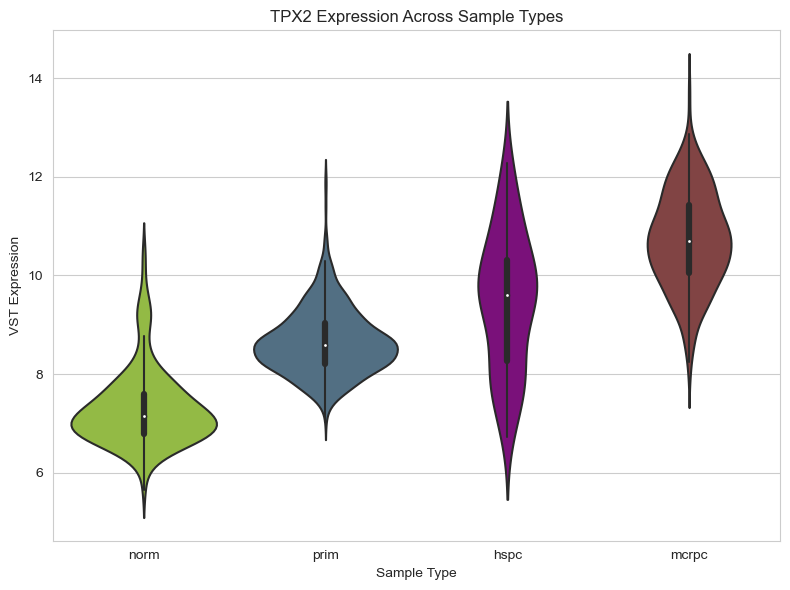

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get TPX2 expression data
tpx2_vst = VST_DF.loc["TPX2"]

# Create a DataFrame for plotting
plot_df = pd.DataFrame(
    {
        "VST Expression": tpx2_vst,
        "Sample Type": ANNOT_DF.loc[tpx2_vst.index, "sample_type"],
    }
)

# Set style and figure size
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Create violin plot
sns.violinplot(
    data=plot_df,
    x="Sample Type",
    y="VST Expression",
    order=CONTRASTS_LEVELS_ORDER,  # Use predefined order: norm -> prim -> hspc -> mcrpc
    palette=CONTRASTS_LEVELS_COLORS,  # Use predefined colors for sample types
)

# Customize plot
plt.title("TPX2 Expression Across Sample Types")
plt.xticks()
plt.tight_layout()

# Save plot
plt.savefig(FIGURES_PATH / "tpx2_expression_violin.pdf")
plt.show()


## 4. Comparison of shared genes with OncotypeDx gene panel

In [32]:
ONCOTYPE_DX_GENES = [
    # Cancer-related genes
    "BGN",
    "COL1A1",
    "SFRP4",
    "AZGP1",
    "KLK2",
    "SRD5A2",
    "FAM13C",
    "FLNC",
    "GSN",
    "GSTM2",
    "TPM2",
    "TPX2",
    # Housekeeping genes
    "RF1",
    "ATP5E",
    "CLTC",
    "GPS1",
    "PGK1",
]

In [33]:
wgcna_ml_results_filt = wgcna_ml_results.loc[
    wgcna_ml_results["SYMBOL"].isin(ONCOTYPE_DX_GENES)
]
display(wgcna_ml_results_filt)

,prim_vs_norm_M3,hspc_vs_prim_M2,mcrpc_vs_hspc_M1,module,stat,SYMBOL,GENENAME,GENETYPE
ENTREZID,,,,,,,,
22974,True,True,True,M3,19.422131,TPX2,TPX2 microtubule nucleation factor,protein-coding
6424,True,False,False,M3,10.034569,SFRP4,secreted frizzled related protein 4,protein-coding
